In [143]:
!pip install --quiet pandas meteomatics scikit-learn python-dotenv

# Fetch weather data from Meteomatics API

In [104]:
import os
import datetime as dt
import pandas as pd
from dateutil.relativedelta import relativedelta
import meteomatics.api as api

from dotenv import load_dotenv

load_dotenv()

MM_USER = os.getenv("METEOMATICS_USER")
MM_PASS = os.getenv("METEOMATICS_PASSWORD")

# Switzerland bbox + grid
LAT_N, LON_W, LAT_S, LON_E = 47.89, 5.77, 45.74, 10.65
RES_LAT, RES_LON = 0.25, 0.25

# Weather parameters (no panel metadata)
parameters = [
    "global_rad:W",
    "direct_rad:W",
    "diffuse_rad:W",
    "effective_cloud_cover:octas",
    "t_2m:C",
    # "dew_point_2m:C",
    "relative_humidity_2m:p",
    "wind_speed_10m:ms",
    "precip_1h:mm",
    "snow_depth:cm",
    "fresh_snow_1h:cm",
    # "msl_pressure:hPa"
]

interval = dt.timedelta(hours=1)
start = dt.datetime(2017, 1, 1)
end   = dt.datetime(2018, 1, 1)

out_dir = "data/processed/meteomatics_weather_hourly_2017"
os.makedirs(out_dir, exist_ok=True)

def month_chunks(a, b):
    cur = a
    while cur < b:
        nxt = cur + relativedelta(months=1)
        yield cur, min(nxt, b)
        cur = nxt

for s, e in month_chunks(start, end):
    print(f"fetch {s} - {e}")
    df = api.query_grid_timeseries(
        s, e, interval,
        parameters,
        LAT_N, LON_W, LAT_S, LON_E,
        RES_LAT, RES_LON,
        MM_USER, MM_PASS,
        request_type="POST",
        interp_select="lapse_rate"
    )

    df = df.reset_index()
    t = df["validdate"].dt.tz_convert("Europe/Zurich")
    df.assign(
        hour       = t.dt.hour,
        dow        = t.dt.dayofweek,
        is_weekend = (t.dt.dayofweek >= 5).astype(int),
        month      = t.dt.month,
        day        = t.dt.day,
        ts_local   = t.dt.tz_localize(None)   # naive local timestamp
    )

    path = os.path.join(out_dir, f"{s:%Y%m%d}_{e:%Y%m%d}.csv")
    df.to_csv(path)


fetch 2017-01-01 00:00:00 - 2017-02-01 00:00:00
fetch 2017-02-01 00:00:00 - 2017-03-01 00:00:00
fetch 2017-03-01 00:00:00 - 2017-04-01 00:00:00
fetch 2017-04-01 00:00:00 - 2017-05-01 00:00:00
fetch 2017-05-01 00:00:00 - 2017-06-01 00:00:00
fetch 2017-06-01 00:00:00 - 2017-07-01 00:00:00
fetch 2017-07-01 00:00:00 - 2017-08-01 00:00:00
fetch 2017-08-01 00:00:00 - 2017-09-01 00:00:00
fetch 2017-09-01 00:00:00 - 2017-10-01 00:00:00
fetch 2017-10-01 00:00:00 - 2017-11-01 00:00:00
fetch 2017-11-01 00:00:00 - 2017-12-01 00:00:00
fetch 2017-12-01 00:00:00 - 2018-01-01 00:00:00


# Simple Baseline
# Daily Aggregation Model (Random Forest)

This model predicts **daily national PV production** (and optionally **electricity consumption**)  
using **daily aggregated weather features** and simple calendar variables.  
It provides a strong baseline using easily interpretable, non-sequential features.

## Approach

- We aggregate **hourly weather data** into **daily summaries**:
  - **Sum** and **mean** of solar radiation
  - **Min**, **max**, **mean** of temperature
  - **Mean** of humidity, wind speed, cloud cover
  - **Sum** of precipitation
- We also add **calendar features**:
  - **Month**, **day of week**, and **weekend flag**
- Optionally, we join **daily national consumption** for multi-target analysis.

## Target

The primary target is:
- `pv_production_gwh`: **Daily photovoltaic production** (in GWh)

Optionally:
- `national_consumption_gwh`: **Daily electricity consumption**

## Model

- We use a **Random Forest Regressor** (300 trees) to map aggregated weather features  
  to daily PV production (and/or consumption).
- Missing data are imputed using **median values** via a `SimpleImputer`.

### Input features
- Aggregated weather statistics (radiation, temperature, humidity, etc.)
- Calendar features (month, day of week, weekend)

### Output
- Predicted **daily PV generation** in GWh

## Training & Evaluation

- Data is split **chronologically**: 80% train / 20% validation  
  (no shuffling, to preserve time ordering)
- Metrics:
  - **MAE** (Mean Absolute Error)
  - **R²** (Coefficient of Determination)

- Validation predictions are plotted against actual daily values.

## Advantages

- **Simple and interpretable**
- Requires only **daily aggregated weather data**
- Fast to train and easy to deploy
- Serves as a strong **baseline** for more complex temporal models (MLP, LSTM)

## Limitations

- Ignores **hourly dynamics** (e.g., cloud cover timing)
- Cannot capture **temporal dependencies** beyond daily summaries
- May underperform during **rapidly changing weather patterns**


In [138]:
import pandas as pd


# energy consumption
df_con = (
    pd.read_csv("data/raw/ogd103_stromverbrauch_swissgrid_lv_und_endv.csv")
      .rename(columns={
          "Datum": "date",
          "Landesverbrauch_GWh": "national_consumption_gwh",
          "Endverbrauch_GWh": "end_consumption_gwh",
      })
      .dropna(subset=["date"])
)
df_con["date"] = pd.to_datetime(df_con["date"])

# PV production
df_pv = (
    pd.read_csv("data/raw/ogd104_stromproduktion_swissgrid.csv")
      .rename(columns={
          "Datum": "date",
          "Energietraeger": "energy_carrier",
          "Produktion_GWh": "production_gwh",
      })
)
df_pv = (
    df_pv[df_pv["energy_carrier"].str.lower().eq("photovoltaik")]
      .drop(columns=["energy_carrier"])
)
df_pv["date"] = pd.to_datetime(df_pv["date"])
df_pv = df_pv.groupby("date", as_index=False)["production_gwh"].sum() \
             .rename(columns={"production_gwh": "pv_production_gwh"})

# weather
df_w = pd.concat(
    [
        pd.read_csv(
            os.path.join(out_dir, f),
            parse_dates=["validdate"]   # 👈 convert to datetime
        )
        for f in os.listdir(out_dir)
        if f.endswith(".csv")
    ],
    ignore_index=True
)
df_w["date"] = pd.to_datetime(df_w["validdate"]).dt.date
df_w = df_w.groupby("date").agg({
    "global_rad:W": ["sum", "mean"],
    "t_2m:C": ["min", "max", "mean"],
    "relative_humidity_2m:p": "mean",
    "wind_speed_10m:ms": "mean",
    "precip_1h:mm": "sum",
    "snow_depth:cm": "mean",
    "effective_cloud_cover:octas": "mean"
})
df_w.columns = ["_".join(c) for c in df_w.columns]
df_w = df_w.reset_index().rename(columns={"date": "date"})
df_w["date"] = pd.to_datetime(df_w["date"])
df_w["month"] = df_w["date"].dt.month
df_w["dow"] = df_w["date"].dt.dayofweek
df_w["is_weekend"] = (df_w["dow"] >= 5).astype(int)

# join weather + consumption + pv on date
df_all = (
    df_w.merge(df_con, on="date", how="left")
       .merge(df_pv, on="date", how="left")
       .sort_values("date")
       .reset_index(drop=True)
)

df_all.head()


,date,global_rad:W_sum,global_rad:W_mean,t_2m:C_min,t_2m:C_max,t_2m:C_mean,relative_humidity_2m:p_mean,wind_speed_10m:ms_mean,precip_1h:mm_sum,snow_depth:cm_mean,effective_cloud_cover:octas_mean,month,dow,is_weekend,national_consumption_gwh,end_consumption_gwh,pv_production_gwh
0,2017-01-01,307321.9,71.139329,-13.8,9.7,0.192963,42.000532,1.355556,0.49,8.436806,0.099306,1,6,1,170.0,150.0,2.2
1,2017-01-02,209969.3,48.604005,-17.6,8.4,-1.618032,62.604028,1.814375,141.26,8.566667,3.742361,1,0,0,179.0,162.0,1.6
2,2017-01-03,304991.3,70.599838,-21.3,7.1,-3.866273,65.697778,2.035000,8.53,9.044213,0.545370,1,1,0,200.0,183.0,2.0
3,2017-01-04,165737.3,38.365116,-22.3,10.8,-2.784491,69.839537,3.648843,602.13,9.791667,3.804398,1,2,0,202.0,188.0,1.2
4,2017-01-05,196172.9,45.410394,-27.5,4.9,-7.108773,72.939190,3.712014,438.01,12.603009,2.643981,1,3,0,207.0,190.0,1.3


pv_production_gwh: MAE=0.622 | R2=-0.311


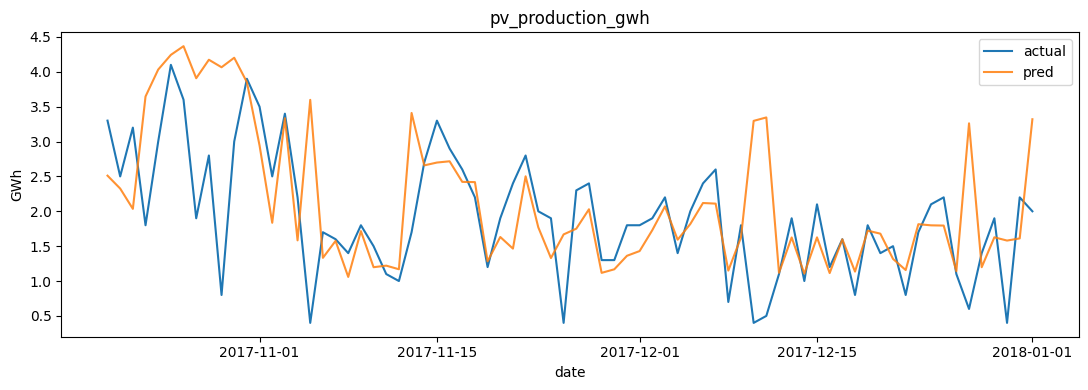

national_consumption_gwh: MAE=5.204 | R2=0.805


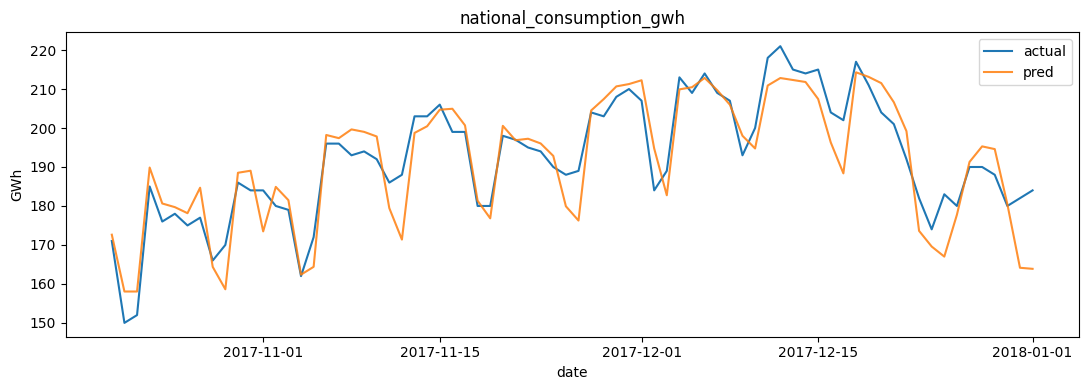

In [166]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

df = df_all.copy()
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date").reset_index(drop=True)

targets = ["pv_production_gwh", "national_consumption_gwh"]
drop_cols = set(["date"]) | set(targets)
feature_cols = [c for c in df.columns if c not in drop_cols]

for target in targets:
    dft = df.dropna(subset=[target]).reset_index(drop=True)
    X = dft[feature_cols]
    y = dft[target]
    t = dft["date"]

    X_train, X_val, y_train, y_val, t_train, t_val = train_test_split(
        X, y, t, test_size=0.2, shuffle=False
    )

    model = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("rf", RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1))
    ])

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    print(f"{target}: MAE={mean_absolute_error(y_val, y_pred):.3f} | R2={r2_score(y_val, y_pred):.3f}")

    plt.figure(figsize=(11,4))
    plt.plot(t_val, y_val.values, label="actual")
    plt.plot(t_val, y_pred, label="pred", alpha=0.85)
    plt.title(f"{target}")
    plt.xlabel("date"); plt.ylabel("GWh"); plt.legend(); plt.tight_layout()
    plt.show()


The model predicts daily PV production and electricity consumption using weather data from the previous n days (lags) and calendar features (month, weekday, weekend).

# Time Series Modeling

# Weak Supervision Model (MLP)

This model estimates **daily national PV production** using **hourly weather data** from multiple locations.  
We don’t have hourly PV labels, so the model learns indirectly by matching the **sum of hourly predictions** to the **daily observed PV total**.

## Approach

- Each training sample represents a **(location, hour)** pair.
- The input features are the **previous _n_ hours** of weather data (e.g. radiation, temperature, humidity, wind, etc.).
- A simple **MLP** predicts an intermediate hourly PV value.
- For each day, all predicted hourly values across all locations are **summed** to get the model’s **daily PV estimate**.

The model is trained so that this daily sum matches the actual **national daily PV production**.

## Loss

We use the **Huber loss** between the predicted and actual daily totals.  
It behaves like MSE for small errors but is less sensitive to outliers (days with unusual production).

## What the model learns

- The relationship between weather and PV generation.
- How to assign importance to time features (hour of day, day of year).
- How different weather conditions contribute to total daily PV, even without hourly ground truth.

## Why this setup

- We only need **daily PV data**, which is much easier to get.
- The model can still learn meaningful hourly patterns through **weak supervision**.
- Simple, scalable, and can be extended later with more advanced models.



In [66]:
import os, numpy as np, pandas as pd

out_dir = "data/processed/meteomatics_weather_hourly_2017"

feat_cols = [
    "global_rad:W","t_2m:C","relative_humidity_2m:p",
    "wind_speed_10m:ms","precip_1h:mm","snow_depth:cm","effective_cloud_cover:octas"
]

hourly = pd.concat(
    [pd.read_csv(os.path.join(out_dir, f), parse_dates=["validdate"])
     for f in os.listdir(out_dir) if f.endswith(".csv")],
    ignore_index=True
)

if pd.api.types.is_datetime64tz_dtype(hourly["validdate"]):
    hourly["validdate"] = hourly["validdate"].dt.tz_convert("UTC").dt.tz_localize(None)

hourly["date"] = hourly["validdate"].dt.floor("D")
hourly["hour"] = hourly["validdate"].dt.hour

# time + location encodings
idx = pd.DatetimeIndex(hourly["validdate"])
hourly["hour_sin"] = np.sin(2*np.pi*idx.hour/24)
hourly["hour_cos"] = np.cos(2*np.pi*idx.hour/24)
hourly["doy_sin"]  = np.sin(2*np.pi*idx.dayofyear/365.25)
hourly["doy_cos"]  = np.cos(2*np.pi*idx.dayofyear/365.25)
hourly["lat_n"]    = (hourly["lat"]-hourly["lat"].min())/(hourly["lat"].max()-hourly["lat"].min()+1e-9)
hourly["lon_n"]    = (hourly["lon"]-hourly["lon"].min())/(hourly["lon"].max()-hourly["lon"].min()+1e-9)

feat_cols = feat_cols + ["hour_sin","hour_cos","doy_sin","doy_cos","lat_n","lon_n"]

hourly = hourly[["lat","lon","date","hour","validdate"] + feat_cols]
hourly = hourly.sort_values(["lat","lon","date","hour"])  # ensure hour order within group

gkeys = ["lat","lon","date"]

# keep only groups with exactly 24 rows AND 24 distinct hours
df24 = (
    hourly.groupby(gkeys, group_keys=False)
          .filter(lambda g: len(g) == 24 and g["hour"].nunique() == 24)
)

# aggregate each feature into a 24-length list per (lat,lon,date)
df_lists = (
    df24.groupby(gkeys, as_index=False)[feat_cols]
        .agg(list)
)

# df_lists now has one row per (lat,lon,date); each feature column is a length-24 list
print(len(df_lists))
df_lists.head()


/tmp/ipykernel_17094/727391197.py:16: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(hourly["validdate"]):


63720


,lat,lon,date,global_rad:W,t_2m:C,relative_humidity_2m:p,wind_speed_10m:ms,precip_1h:mm,snow_depth:cm,effective_cloud_cover:octas,hour_sin,hour_cos,doy_sin,doy_cos,lat_n,lon_n
0,45.74,5.77,2017-01-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.1,...","[4.7, -0.1, 1.7, 1.0, 1.7, 1.2, 1.4, 1.6, 2.5,...","[42.1, 64.5, 50.6, 50.1, 46.6, 46.4, 44.3, 41....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.25881904510252074, 0.49999999999999994...","[1.0, 0.9659258262890683, 0.8660254037844387, ...","[0.017201575418260506, 0.017201575418260506, 0...","[0.9998520419557735, 0.9998520419557735, 0.999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,45.74,5.77,2017-01-02,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.1,...","[3.8, -0.4, 1.0, 1.2, 1.0, 1.5, 2.0, 1.9, 1.6,...","[66.8, 86.8, 76.4, 68.5, 65.9, 61.9, 57.6, 58....","[0.6, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 5.0, ...","[0.0, 0.25881904510252074, 0.49999999999999994...","[1.0, 0.9659258262890683, 0.8660254037844387, ...","[0.03439806061360801, 0.03439806061360801, 0.0...","[0.9994082116062598, 0.9994082116062598, 0.999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,45.74,5.77,2017-01-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.9,...","[-1.4, -0.5, 0.0, 0.4, -0.0, -0.3, -0.2, -0.7,...","[86.4, 93.8, 92.0, 84.9, 81.2, 80.1, 73.7, 70....","[0.8, 0.8, 0.9, 1.0, 1.3, 1.6, 2.0, 2.1, 2.3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.25881904510252074, 0.49999999999999994...","[1.0, 0.9659258262890683, 0.8660254037844387, ...","[0.051584366869408364, 0.051584366869408364, 0...","[0.9986686402879997, 0.9986686402879997, 0.998...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,45.74,5.77,2017-01-04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.1, ...","[-1.1, -1.8, -1.6, -1.5, -1.5, -1.4, -1.2, -1....","[68.3, 86.2, 83.4, 80.6, 78.6, 76.3, 73.0, 69....","[0.7, 0.6, 0.5, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 5.0, 7.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.25881904510252074, 0.49999999999999994...","[1.0, 0.9659258262890683, 0.8660254037844387, ...","[0.06875540848113941, 0.06875540848113941, 0.0...","[0.9976335468520451, 0.9976335468520451, 0.997...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,45.74,5.77,2017-01-05,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.2,...","[1.0, 0.3, 0.5, 0.5, 0.3, 0.2, -0.1, 0.6, -0.0...","[81.7, 82.6, 78.8, 78.4, 76.7, 74.1, 73.6, 70....","[1.2, 0.9, 0.6, 0.3, 0.7, 1.0, 1.4, 1.3, 1.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.25881904510252074, 0.49999999999999994...","[1.0, 0.9659258262890683, 0.8660254037844387, ...","[0.08590610426133272, 0.08590610426133272, 0.0...","[0.9963032375991965, 0.9963032375991965, 0.996...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


50940 / 63720
Epoch 01 | Train 343.1069 | Val 104.3655
Epoch 02 | Train 59.6089 | Val 1.8633
Epoch 03 | Train 1.6403 | Val 0.2562
Epoch 04 | Train 1.3724 | Val 0.2798
Epoch 05 | Train 1.2170 | Val 0.2808
Epoch 06 | Train 1.2939 | Val 0.2806
Epoch 07 | Train 1.1919 | Val 0.2774
Epoch 08 | Train 1.2067 | Val 0.2757
Epoch 09 | Train 1.2134 | Val 0.2724
Epoch 10 | Train 1.2399 | Val 0.2733
Epoch 11 | Train 0.9689 | Val 0.2665
Epoch 12 | Train 0.8798 | Val 0.2655
Epoch 13 | Train 0.8421 | Val 0.2629
Epoch 14 | Train 0.7620 | Val 0.2512
Epoch 15 | Train 0.7727 | Val 0.2288
Epoch 16 | Train 0.8683 | Val 0.2482
Epoch 17 | Train 0.6114 | Val 0.2123
Epoch 18 | Train 0.5192 | Val 0.1597
Epoch 19 | Train 0.4898 | Val 0.1612
Epoch 20 | Train 0.4301 | Val 0.1747
Epoch 21 | Train 0.4350 | Val 0.1641
Epoch 22 | Train 0.4183 | Val 0.2378
Epoch 23 | Train 0.5895 | Val 0.1544
Epoch 24 | Train 0.4636 | Val 0.1802
Epoch 25 | Train 0.3273 | Val 0.1833
Epoch 26 | Train 0.3599 | Val 0.1558
Epoch 27 | Train 0.

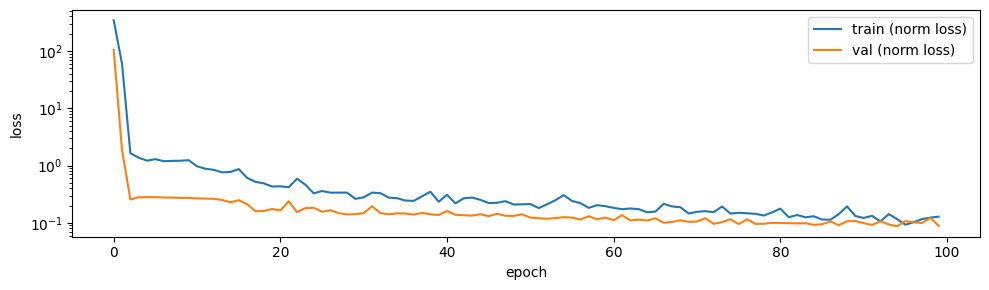

In [80]:
import numpy as np, pandas as pd, torch, torch.nn as nn
from numpy.lib.stride_tricks import sliding_window_view
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, r2_score

# ---- config ----
n = 3                                  # previous hours
F = len(feat_cols)

# ==== build (N, 24, F) ====
feat_24 = np.stack([np.stack(df_lists[c].to_numpy()) for c in feat_cols], axis=-1)  # (N, 24, F)
dates_row = pd.to_datetime(df_lists["date"]).values                             # (N,)

# ==== chronological split on DAYS ====
days = np.array(sorted(pd.to_datetime(df_lists["date"].unique())))
cut = int(len(days)*0.8)
train_days = set(days[:cut]); val_days = set(days[cut:])
train_days = pd.to_datetime(list(train_days)).values

row_train_mask = np.isin(dates_row, train_days)
print(row_train_mask.sum(), "/", len(row_train_mask))


# ==== per-feature scaling on TRAIN rows, then apply to ALL ====
tr = feat_24[row_train_mask]                  # (N_tr, 24, F)
mu = tr.reshape(-1, F).mean(axis=0)           # (F,)
sd = tr.reshape(-1, F).std(axis=0) + 1e-8     # (F,)
feat_24 = (feat_24 - mu) / sd                 # scaled (N, 24, F)

# ==== sliding windows (prev n hours), drop last window so target ∈ [n..23] ====
wins = sliding_window_view(feat_24, window_shape=n, axis=1)  # (N, 24-n+1, F, n)
wins = wins.transpose((0, 1, 3, 2))                          # -> (N, 24-n+1, n, F)
wins = wins[:, :-1, :, :]                                    # -> (N, 24-n, n, F)
N, H, _, _ = wins.shape                                       # H = 24 - n
hours_target = np.arange(n, 24)
assert H == len(hours_target)

# flatten per-row samples
X_seq  = wins.reshape(-1, n, F)                               # (samples, n, F)
X_flat = X_seq.reshape(X_seq.shape[0], n*F).astype(np.float32)# (samples, n*F)

# ==== keys for each sample (loc, date, hour) ====
keys = pd.DataFrame({
    "lat":  np.repeat(df_lists["lat"].to_numpy(),  H),
    "lon":  np.repeat(df_lists["lon"].to_numpy(),  H),
    "date": np.repeat(pd.to_datetime(df_lists["date"]).to_numpy(), H),
    "hour": np.tile(hours_target, len(df_lists))
})
assert len(keys) == len(X_flat)

# ==== pack per-day matrices: X_day in (M_d, D), daily PV target y_day ====
# daily national PV
pv_daily = (
    pd.read_csv("data/raw/ogd104_stromproduktion_swissgrid.csv")
      .rename(columns={"Datum":"date","Energietraeger":"energy_carrier","Produktion_GWh":"pv_gwh"})
)
pv_daily = pv_daily[pv_daily["energy_carrier"].str.lower().eq("photovoltaik")].drop(columns=["energy_carrier"])
pv_daily["date"] = pd.to_datetime(pv_daily["date"])
pv_map = dict(zip(pv_daily["date"].values, pv_daily["pv_gwh"].values))

# group row-samples by day
grp = keys.groupby("date").indices
dates_sorted = np.array(sorted(grp.keys()))

X_days, y_days, ds_days = [], [], []
for d in dates_sorted:
    idxs = grp[d]
    if d not in pv_map: 
        continue
    X_days.append(torch.from_numpy(X_flat[idxs]).float())  # (M_d, n*F): all (loc,hour) rows for that day
    y_days.append(torch.tensor(float(pv_map[d])))
    ds_days.append(d)

# split by the same day sets
train = [(x,y,d) for x,y,d in zip(X_days, y_days, ds_days) if d in train_days]
val   = [(x,y,d) for x,y,d in zip(X_days, y_days, ds_days) if d in val_days]

# ==== DataLoaders (pad rows per day) ====
def collate_pad(batch):
    Xs, Ys, Ds = zip(*batch)
    Mmax = max(x.shape[0] for x in Xs); B, D = len(Xs), Xs[0].shape[1]
    Xb = torch.zeros((B, Mmax, D), dtype=torch.float32)
    Mb = torch.zeros((B, Mmax),    dtype=torch.float32)
    for i, x in enumerate(Xs):
        m = x.shape[0]; Xb[i, :m] = x; Mb[i, :m] = 1.0
    Yb = torch.stack(Ys)  # (B,)
    return Xb, Mb, Yb, Ds

train_dl = DataLoader(train, batch_size=64, shuffle=True,  collate_fn=collate_pad)
val_dl   = DataLoader(val,   batch_size=64, shuffle=False, collate_fn=collate_pad)

# ==== model: per-row MLP → hourly PV ≥ 0; daily sum ====
class RowMLP(nn.Module):
    def __init__(self, d_in, hidden=128, use_calib=False):
        super().__init__()
        self.fc1 = nn.Linear(d_in, hidden)
        self.act = nn.ReLU()
        self.fc2 = nn.Linear(hidden, 1)
        self.out_relu = nn.ReLU()
        self.use_calib = use_calib
        if use_calib:
            self.calib = nn.Linear(1, 1)
            nn.init.constant_(self.calib.weight, 1.0); nn.init.constant_(self.calib.bias, 0.0)
        nn.init.xavier_uniform_(self.fc1.weight); nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight); nn.init.zeros_(self.fc2.bias)
    def forward(self, X, M, y_mean=None, y_std=None):
        B, Mmax, D = X.shape
        z = X.view(B*Mmax, D)
        z = self.act(self.fc1(z))
        z = self.out_relu(self.fc2(z)).view(B, Mmax)  # per-row hourly PV
        z = z * M
        y_day = z.sum(dim=1, keepdim=True)            # (B,1)
        if self.use_calib: y_day = self.calib(y_day)
        if (y_mean is not None) and (y_std is not None):
            y_day = (y_day - y_mean) / y_std
        return y_day.squeeze(1)

device = "cuda" if torch.cuda.is_available() else "cpu"
model  = RowMLP(d_in=n*F, hidden=128, use_calib=False).to(device)

# target normalization on TRAIN days only
y_train = torch.stack([y for _,y,_ in train]); y_mean = y_train.mean().item(); y_std = y_train.std().item() + 1e-8
y_mean_t = torch.tensor(y_mean, device=device); y_std_t = torch.tensor(y_std, device=device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.HuberLoss(delta=1.0)
clip_grad = 1.0

import matplotlib.pyplot as plt

train_hist, val_hist = [], []

# ==== train ====
for epoch in range(100):
    model.train(); tr_loss=0; ntr=0
    for Xb, Mb, Yb, _ in train_dl:
        Xb, Mb, Yb = Xb.to(device), Mb.to(device), Yb.to(device)
        opt.zero_grad()
        y_hat_n = model(Xb, Mb, y_mean_t, y_std_t)
        yb_n    = (Yb - y_mean_t)/y_std_t
        loss = loss_fn(y_hat_n.view(-1), yb_n.view(-1))
        loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), clip_grad); opt.step()
        tr_loss += loss.item(); ntr += 1

    model.eval(); va_loss=0; nva=0; yh=[]; yt=[]
    with torch.no_grad():
        for Xb, Mb, Yb, _ in val_dl:
            Xb, Mb, Yb = Xb.to(device), Mb.to(device), Yb.to(device)
            y_hat_n = model(Xb, Mb, y_mean_t, y_std_t)
            yb_n    = (Yb - y_mean_t)/y_std_t
            loss = loss_fn(y_hat_n.view(-1), yb_n.view(-1))
            va_loss += loss.item(); nva += 1
            yh.append((y_hat_n*y_std_t + y_mean_t).cpu().numpy()); yt.append(Yb.cpu().numpy())

    tr_avg = tr_loss/max(ntr,1)
    va_avg = va_loss/max(nva,1)
    train_hist.append(tr_avg); val_hist.append(va_avg)
    print(f"Epoch {epoch+1:02d} | Train {tr_avg:.4f} | Val {va_avg:.4f}")

# ==== metrics ====
yh = np.concatenate(yh); yt = np.concatenate(yt)
print("Val MAE:", mean_absolute_error(yt, yh), "R2:", r2_score(yt, yh))

# ---- plot loss curves ----
plt.figure(figsize=(10,3))
plt.semilogy(train_hist, label="train (norm loss)")
plt.semilogy(val_hist, label="val (norm loss)")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()


MAE=0.980  R2=-0.858  (n=71)


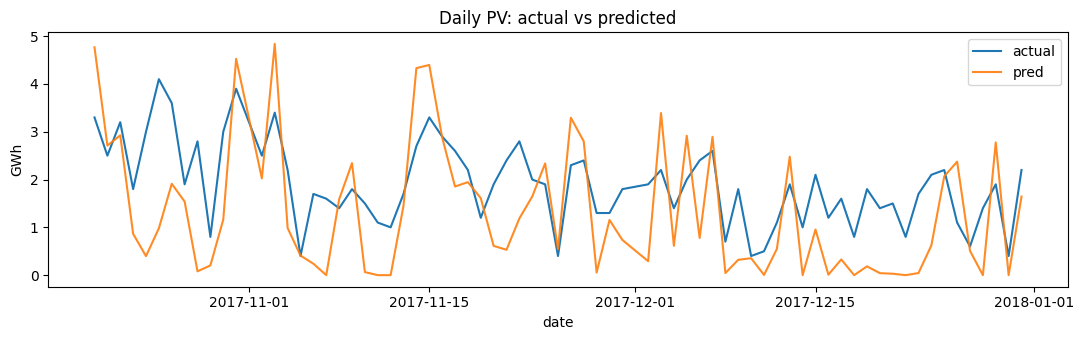

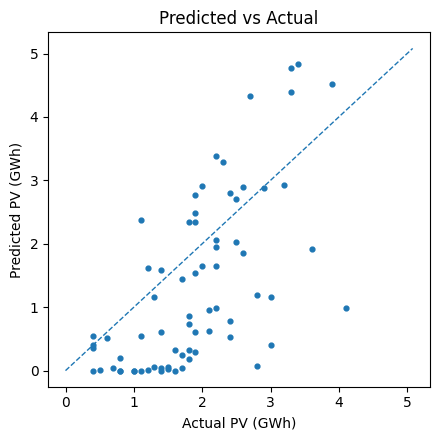

In [87]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch
from numpy.lib.stride_tricks import sliding_window_view

def predict_daily(df_lists_new, model):
    model.eval()
    feat_24 = np.stack([np.stack(df_lists_new[c].to_numpy()) for c in feat_cols], axis=-1).astype(np.float32)
    dates_row = pd.to_datetime(df_lists_new["date"]).to_numpy()
    feat_24 = (feat_24 - mu) / sd
    wins = sliding_window_view(feat_24, window_shape=n, axis=1).transpose((0,1,3,2))
    wins = wins[:, :-1, :, :]
    if wins.size == 0:
        return pd.DataFrame(columns=["date","y_hat"])
    N, H, _, F = wins.shape
    X = wins.reshape(-1, n*F)
    keys = pd.DataFrame({"date": np.repeat(dates_row, H)})
    grp = keys.groupby("date").indices
    dates_sorted = np.array(sorted(grp.keys()))
    X_days, ds_days = [], []
    for d in dates_sorted:
        idxs = grp[d]
        X_days.append(torch.from_numpy(X[idxs]).float())
        ds_days.append(pd.Timestamp(d))
    def collate_pad(batch):
        Xs, Ds = zip(*batch)
        Mmax = max(x.shape[0] for x in Xs); B, D = len(Xs), Xs[0].shape[1]
        Xb = torch.zeros((B, Mmax, D)); Mb = torch.zeros((B, Mmax))
        for i, x in enumerate(Xs):
            m = x.shape[0]; Xb[i,:m]=x; Mb[i,:m]=1.0
        return Xb, Mb, Ds
    infer_ds = list(zip(X_days, ds_days))
    infer_dl = DataLoader(infer_ds, batch_size=64, shuffle=False, collate_fn=collate_pad)
    preds, dates_out = [], []
    with torch.no_grad():
        for Xb, Mb, Ds in infer_dl:
            Xb, Mb = Xb.to(device), Mb.to(device)
            y_hat_n = model(Xb, Mb, y_mean_t, y_std_t)
            y_hat = (y_hat_n*y_std_t + y_mean_t).cpu().numpy()
            preds.append(y_hat); dates_out.extend(Ds)
    y_hat = np.concatenate(preds)
    return pd.DataFrame({"date": pd.to_datetime(dates_out), "y_hat": y_hat}).sort_values("date").reset_index(drop=True)

def test_and_plot(df_lists, pv, model):
    pred = predict_daily(df_lists, model)
    df = pred.merge(pv, on="date", how="inner").sort_values("date")
    if df.empty:
        print("No overlapping dates."); return df
    from sklearn.metrics import mean_absolute_error, r2_score
    mae = mean_absolute_error(df["pv_gwh"], df["y_hat"])
    r2  = r2_score(df["pv_gwh"], df["y_hat"])
    print(f"MAE={mae:.3f}  R2={r2:.3f}  (n={len(df)})")

    plt.figure(figsize=(11,3.5))
    plt.plot(df["date"], df["pv_gwh"], label="actual")
    plt.plot(df["date"], df["y_hat"], label="pred", alpha=0.9)
    plt.title("Daily PV: actual vs predicted"); plt.xlabel("date"); plt.ylabel("GWh")
    plt.legend(); plt.tight_layout(); plt.show()

    lim = max(df["pv_gwh"].max(), df["y_hat"].max()) * 1.05
    plt.figure(figsize=(4.5,4.5))
    plt.scatter(df["pv_gwh"], df["y_hat"], s=12)
    plt.plot([0,lim], [0,lim], lw=1, linestyle="--")
    plt.xlabel("Actual PV (GWh)"); plt.ylabel("Predicted PV (GWh)")
    plt.title("Predicted vs Actual"); plt.tight_layout(); plt.show()
    return df

val_days_arr = pd.to_datetime(list(val_days)).values 

# --- filter df_lists to validation days ---
df_lists_val = df_lists[
    pd.to_datetime(df_lists["date"]).isin(val_days_arr)
].reset_index(drop=True)

# --- filter pv_daily to validation days ---
pv_val = pv_daily[
    pd.to_datetime(pv_daily["date"]).isin(val_days_arr)
].sort_values("date").reset_index(drop=True)

df_eval = test_and_plot(df_lists_val, pv_val, model)

# Weak Supervision Model (LSTM)

This model estimates **daily national PV production** using **hourly weather data** from multiple locations, without access to hourly PV labels.  
It learns by ensuring that the **sum of its hourly predictions** matches the **observed daily PV total**.

## Approach

- Each training sample represents a **(location, hour)** pair.  
- The input is a **sequence** of weather features from the **previous _n_ hours**  
  (e.g. radiation, temperature, humidity, wind, etc.).  
- A **lightweight LSTM** processes each sequence and outputs an intermediate **hourly PV estimate**.  
- For each day, all hourly predictions across all locations are **summed** to form the model’s **daily PV estimate**.

Training minimizes the difference between this **daily estimate** and the **actual national PV total**.

## Loss

We use the **Huber loss** between the predicted and actual daily PV.  
It behaves like MSE for small errors but is **less sensitive to outliers**,  
making training more stable on days with unusual production patterns.

## What the model learns

- **Temporal dependencies**: how PV generation depends on recent weather history.  
- **Feature dynamics**: the impact of short-term trends in radiation, clouds, and temperature.  
- **Aggregate behavior**: how local and hourly conditions combine to produce national daily output.

## Why use LSTM

- Captures **time dependencies** across consecutive hours, which MLPs ignore.  
- Learns smooth temporal representations that reflect real-world PV dynamics.  
- Still trained with only **daily PV totals**, preserving the **weak supervision** setup.

## Benefits

- Requires **only daily PV data** — much easier to obtain than hourly data.  
- More expressive than a simple MLP due to **sequence modeling**.  
- Can be extended for **forecasting** or integrated with **spatial attention** mechanisms.


In [1]:
import os, numpy as np, pandas as pd

out_dir = "data/processed/meteomatics_weather_hourly_2017"

feat_cols = [
    "global_rad:W","t_2m:C","relative_humidity_2m:p",
    "wind_speed_10m:ms","precip_1h:mm","snow_depth:cm","effective_cloud_cover:octas"
]

hourly = pd.concat(
    [pd.read_csv(os.path.join(out_dir, f), parse_dates=["validdate"])
     for f in os.listdir(out_dir) if f.endswith(".csv")],
    ignore_index=True
)

if pd.api.types.is_datetime64tz_dtype(hourly["validdate"]):
    hourly["validdate"] = hourly["validdate"].dt.tz_convert("UTC").dt.tz_localize(None)

hourly["date"] = hourly["validdate"].dt.floor("D")
hourly["hour"] = hourly["validdate"].dt.hour

# time + location encodings
idx = pd.DatetimeIndex(hourly["validdate"])
hourly["hour_sin"] = np.sin(2*np.pi*idx.hour/24)
hourly["hour_cos"] = np.cos(2*np.pi*idx.hour/24)
hourly["doy_sin"]  = np.sin(2*np.pi*idx.dayofyear/365.25)
hourly["doy_cos"]  = np.cos(2*np.pi*idx.dayofyear/365.25)
hourly["lat_n"]    = (hourly["lat"]-hourly["lat"].min())/(hourly["lat"].max()-hourly["lat"].min()+1e-9)
hourly["lon_n"]    = (hourly["lon"]-hourly["lon"].min())/(hourly["lon"].max()-hourly["lon"].min()+1e-9)

feat_cols = feat_cols + ["hour_sin","hour_cos","doy_sin","doy_cos","lat_n","lon_n"]

hourly = hourly[["lat","lon","date","hour","validdate"] + feat_cols]
hourly = hourly.sort_values(["lat","lon","date","hour"])  # ensure hour order within group

gkeys = ["lat","lon","date"]

# keep only groups with exactly 24 rows AND 24 distinct hours
df24 = (
    hourly.groupby(gkeys, group_keys=False)
          .filter(lambda g: len(g) == 24 and g["hour"].nunique() == 24)
)

# aggregate each feature into a 24-length list per (lat,lon,date)
df_lists = (
    df24.groupby(gkeys, as_index=False)[feat_cols]
        .agg(list)
)

# df_lists now has one row per (lat,lon,date); each feature column is a length-24 list
print(len(df_lists))
df_lists.head()


/tmp/ipykernel_26090/727391197.py:16: DeprecationWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if pd.api.types.is_datetime64tz_dtype(hourly["validdate"]):


63720


,lat,lon,date,global_rad:W,t_2m:C,relative_humidity_2m:p,wind_speed_10m:ms,precip_1h:mm,snow_depth:cm,effective_cloud_cover:octas,hour_sin,hour_cos,doy_sin,doy_cos,lat_n,lon_n
0,45.74,5.77,2017-01-01,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.1,...","[4.7, -0.1, 1.7, 1.0, 1.7, 1.2, 1.4, 1.6, 2.5,...","[42.1, 64.5, 50.6, 50.1, 46.6, 46.4, 44.3, 41....","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.25881904510252074, 0.49999999999999994...","[1.0, 0.9659258262890683, 0.8660254037844387, ...","[0.017201575418260506, 0.017201575418260506, 0...","[0.9998520419557735, 0.9998520419557735, 0.999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,45.74,5.77,2017-01-02,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 12.1,...","[3.8, -0.4, 1.0, 1.2, 1.0, 1.5, 2.0, 1.9, 1.6,...","[66.8, 86.8, 76.4, 68.5, 65.9, 61.9, 57.6, 58....","[0.6, 0.8, 0.9, 1.0, 0.9, 0.8, 0.7, 0.6, 0.5, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 5.0, ...","[0.0, 0.25881904510252074, 0.49999999999999994...","[1.0, 0.9659258262890683, 0.8660254037844387, ...","[0.03439806061360801, 0.03439806061360801, 0.0...","[0.9994082116062598, 0.9994082116062598, 0.999...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,45.74,5.77,2017-01-03,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.9,...","[-1.4, -0.5, 0.0, 0.4, -0.0, -0.3, -0.2, -0.7,...","[86.4, 93.8, 92.0, 84.9, 81.2, 80.1, 73.7, 70....","[0.8, 0.8, 0.9, 1.0, 1.3, 1.6, 2.0, 2.1, 2.3, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 5.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.25881904510252074, 0.49999999999999994...","[1.0, 0.9659258262890683, 0.8660254037844387, ...","[0.051584366869408364, 0.051584366869408364, 0...","[0.9986686402879997, 0.9986686402879997, 0.998...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,45.74,5.77,2017-01-04,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 8.1, ...","[-1.1, -1.8, -1.6, -1.5, -1.5, -1.4, -1.2, -1....","[68.3, 86.2, 83.4, 80.6, 78.6, 76.3, 73.0, 69....","[0.7, 0.6, 0.5, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 5.0, 7.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.25881904510252074, 0.49999999999999994...","[1.0, 0.9659258262890683, 0.8660254037844387, ...","[0.06875540848113941, 0.06875540848113941, 0.0...","[0.9976335468520451, 0.9976335468520451, 0.997...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,45.74,5.77,2017-01-05,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 11.2,...","[1.0, 0.3, 0.5, 0.5, 0.3, 0.2, -0.1, 0.6, -0.0...","[81.7, 82.6, 78.8, 78.4, 76.7, 74.1, 73.6, 70....","[1.2, 0.9, 0.6, 0.3, 0.7, 1.0, 1.4, 1.3, 1.2, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.25881904510252074, 0.49999999999999994...","[1.0, 0.9659258262890683, 0.8660254037844387, ...","[0.08590610426133272, 0.08590610426133272, 0.0...","[0.9963032375991965, 0.9963032375991965, 0.996...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


50940 / 63720
Epoch 01 | Train 3.2391 | Val 0.2815
Epoch 02 | Train 1.0213 | Val 0.2597
Epoch 03 | Train 0.8422 | Val 0.2483
Epoch 04 | Train 1.1642 | Val 0.2245
Epoch 05 | Train 0.6199 | Val 0.1964
Epoch 06 | Train 0.5211 | Val 0.2138
Epoch 07 | Train 0.4686 | Val 0.1383
Epoch 08 | Train 0.4521 | Val 0.1227
Epoch 09 | Train 0.4851 | Val 0.6173
Epoch 10 | Train 0.4950 | Val 0.1138
Epoch 11 | Train 0.4005 | Val 0.1216
Epoch 12 | Train 0.3966 | Val 0.1080
Epoch 13 | Train 0.4140 | Val 0.3065
Epoch 14 | Train 0.4263 | Val 0.1406
Epoch 15 | Train 0.3439 | Val 0.1079
Epoch 16 | Train 0.3475 | Val 0.1524
Epoch 17 | Train 0.3227 | Val 0.1443
Epoch 18 | Train 0.3274 | Val 0.1330
Epoch 19 | Train 0.3870 | Val 0.1033
Epoch 20 | Train 0.3260 | Val 0.1375
Epoch 21 | Train 0.4153 | Val 0.1240
Epoch 22 | Train 0.2896 | Val 0.1384
Epoch 23 | Train 0.3040 | Val 0.1234
Epoch 24 | Train 0.2836 | Val 0.0916
Epoch 25 | Train 0.3028 | Val 0.0992
Epoch 26 | Train 0.2868 | Val 0.1169
Epoch 27 | Train 0.2905 

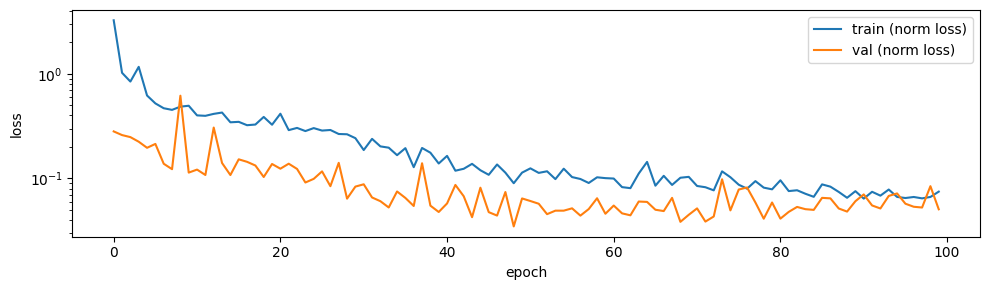

In [2]:
import numpy as np, pandas as pd, torch, torch.nn as nn
from numpy.lib.stride_tricks import sliding_window_view
from torch.utils.data import DataLoader
from sklearn.metrics import mean_absolute_error, r2_score

# ---- config ----
n = 3                                  # previous hours
F = len(feat_cols)

# ==== build (N, 24, F) ====
feat_24 = np.stack([np.stack(df_lists[c].to_numpy()) for c in feat_cols], axis=-1)  # (N, 24, F)
dates_row = pd.to_datetime(df_lists["date"]).values                             # (N,)

# ==== chronological split on DAYS ====
days = np.array(sorted(pd.to_datetime(df_lists["date"].unique())))
cut = int(len(days)*0.8)
train_days = set(days[:cut]); val_days = set(days[cut:])
train_days = pd.to_datetime(list(train_days)).values

row_train_mask = np.isin(dates_row, train_days)
print(row_train_mask.sum(), "/", len(row_train_mask))


# ==== per-feature scaling on TRAIN rows, then apply to ALL ====
tr = feat_24[row_train_mask]                  # (N_tr, 24, F)
mu = tr.reshape(-1, F).mean(axis=0)           # (F,)
sd = tr.reshape(-1, F).std(axis=0) + 1e-8     # (F,)
feat_24 = (feat_24 - mu) / sd                 # scaled (N, 24, F)

# ==== sliding windows (prev n hours), drop last window so target ∈ [n..23] ====
wins = sliding_window_view(feat_24, window_shape=n, axis=1)  # (N, 24-n+1, F, n)
wins = wins.transpose((0, 1, 3, 2))                          # -> (N, 24-n+1, n, F)
wins = wins[:, :-1, :, :]                                    # -> (N, 24-n, n, F)
N, H, _, _ = wins.shape                                       # H = 24 - n
hours_target = np.arange(n, 24)
assert H == len(hours_target)

# flatten per-row samples
X_seq  = wins.reshape(-1, n, F)                               # (samples, n, F)
# X_flat = X_seq.reshape(X_seq.shape[0], n*F).astype(np.float32)# (samples, n*F)

# ==== keys for each sample (loc, date, hour) ====
keys = pd.DataFrame({
    "lat":  np.repeat(df_lists["lat"].to_numpy(),  H),
    "lon":  np.repeat(df_lists["lon"].to_numpy(),  H),
    "date": np.repeat(pd.to_datetime(df_lists["date"]).to_numpy(), H),
    "hour": np.tile(hours_target, len(df_lists))
})
assert len(keys) == len(X_seq)

# ==== pack per-day matrices: X_day in (M_d, D), daily PV target y_day ====
# daily national PV
pv_daily = (
    pd.read_csv("data/raw/ogd104_stromproduktion_swissgrid.csv")
      .rename(columns={"Datum":"date","Energietraeger":"energy_carrier","Produktion_GWh":"pv_gwh"})
)
pv_daily = pv_daily[pv_daily["energy_carrier"].str.lower().eq("photovoltaik")].drop(columns=["energy_carrier"])
pv_daily["date"] = pd.to_datetime(pv_daily["date"])
pv_map = dict(zip(pv_daily["date"].values, pv_daily["pv_gwh"].values))

# group row-samples by day
grp = keys.groupby("date").indices
dates_sorted = np.array(sorted(grp.keys()))

X_days, y_days, ds_days = [], [], []
for d in dates_sorted:
    idxs = grp[d]
    if d not in pv_map: 
        continue
    X_days.append(torch.from_numpy(X_seq[idxs]).float())  # (M_d, n*F): all (loc,hour) rows for that day
    y_days.append(torch.tensor(float(pv_map[d])))
    ds_days.append(d)

# split by the same day sets
train = [(x,y,d) for x,y,d in zip(X_days, y_days, ds_days) if d in train_days]
val   = [(x,y,d) for x,y,d in zip(X_days, y_days, ds_days) if d in val_days]

# ==== DataLoaders (pad rows per day) ====
def collate_pad(batch):
    Xs, Ys, Ds = zip(*batch)
    Mmax = max(x.shape[0] for x in Xs)
    B, n, F = len(Xs), Xs[0].shape[1], Xs[0].shape[2]
    Xb = torch.zeros((B, Mmax, n, F), dtype=torch.float32)
    Mb = torch.zeros((B, Mmax),      dtype=torch.float32)
    for i, x in enumerate(Xs):
        m = x.shape[0]
        Xb[i, :m] = x
        Mb[i, :m] = 1.0
    Yb = torch.stack(Ys)  # (B,)
    return Xb, Mb, Yb, Ds
    
train_dl = DataLoader(train, batch_size=8, shuffle=True,  collate_fn=collate_pad)
val_dl   = DataLoader(val,   batch_size=8, shuffle=False, collate_fn=collate_pad)

class RowLSTM(nn.Module):
    def __init__(self, in_dim, hidden=128, layers=1, bidir=False, dropout=0.0, use_calib=False):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_dim, hidden_size=hidden, num_layers=layers,
            batch_first=True, bidirectional=bidir,
            dropout=dropout if layers > 1 else 0.0
        )
        out_dim = hidden * (2 if bidir else 1)
        self.head = nn.Linear(out_dim, 1)
        self.relu = nn.ReLU()
        self.use_calib = use_calib
        if use_calib:
            self.calib = nn.Linear(1, 1)
            nn.init.constant_(self.calib.weight, 1.0); nn.init.constant_(self.calib.bias, 0.0)
        nn.init.xavier_uniform_(self.head.weight); nn.init.zeros_(self.head.bias)

    def forward(self, X, M, y_mean=None, y_std=None):
        # X: (B, Mmax, n, F)  -> process each row’s (n,F) sequence
        B, Mmax, n, F = X.shape
        z = X.view(B*Mmax, n, F)                # (BM, n, F)
        o, _ = self.lstm(z)                     # (BM, n, H)
        h_last = o[:, -1, :]                    # (BM, H)
        y_row = self.relu(self.head(h_last)).view(B, Mmax)   # hourly PV per row ≥ 0
        y_row = y_row * M                       # mask padding
        y_day = y_row.sum(dim=1, keepdim=True)  # (B,1)
        if self.use_calib:
            y_day = self.calib(y_day)
        if (y_mean is not None) and (y_std is not None):
            y_day = (y_day - y_mean) / y_std
        return y_day.squeeze(1)                 # (B,)

device = "cuda" if torch.cuda.is_available() else "cpu"
model  = RowLSTM(in_dim=F, hidden=128, layers=1, bidir=False, dropout=0.0, use_calib=False).to(device)

# target normalization on TRAIN days only
y_train = torch.stack([y for _,y,_ in train]); y_mean = y_train.mean().item(); y_std = y_train.std().item() + 1e-8
y_mean_t = torch.tensor(y_mean, device=device); y_std_t = torch.tensor(y_std, device=device)

opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
loss_fn = nn.HuberLoss(delta=1.0)
clip_grad = 1.0

import matplotlib.pyplot as plt

train_hist, val_hist = [], []

# ==== train ====
for epoch in range(100):
    model.train(); tr_loss=0; ntr=0
    for Xb, Mb, Yb, _ in train_dl:
        Xb, Mb, Yb = Xb.to(device), Mb.to(device), Yb.to(device)
        opt.zero_grad()
        y_hat_n = model(Xb, Mb, y_mean_t, y_std_t)
        yb_n    = (Yb - y_mean_t)/y_std_t
        loss = loss_fn(y_hat_n.view(-1), yb_n.view(-1))
        loss.backward(); nn.utils.clip_grad_norm_(model.parameters(), clip_grad); opt.step()
        tr_loss += loss.item(); ntr += 1

    model.eval(); va_loss=0; nva=0; yh=[]; yt=[]
    with torch.no_grad():
        for Xb, Mb, Yb, _ in val_dl:
            Xb, Mb, Yb = Xb.to(device), Mb.to(device), Yb.to(device)
            y_hat_n = model(Xb, Mb, y_mean_t, y_std_t)
            yb_n    = (Yb - y_mean_t)/y_std_t
            loss = loss_fn(y_hat_n.view(-1), yb_n.view(-1))
            va_loss += loss.item(); nva += 1
            yh.append((y_hat_n*y_std_t + y_mean_t).cpu().numpy()); yt.append(Yb.cpu().numpy())

    tr_avg = tr_loss/max(ntr,1)
    va_avg = va_loss/max(nva,1)
    train_hist.append(tr_avg); val_hist.append(va_avg)
    print(f"Epoch {epoch+1:02d} | Train {tr_avg:.4f} | Val {va_avg:.4f}")

# ==== metrics ====
yh = np.concatenate(yh); yt = np.concatenate(yt)
print("Val MAE:", mean_absolute_error(yt, yh), "R2:", r2_score(yt, yh))

# ---- plot loss curves ----
plt.figure(figsize=(10,3))
plt.semilogy(train_hist, label="train (norm loss)")
plt.semilogy(val_hist, label="val (norm loss)")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.legend(); plt.tight_layout(); plt.show()


MAE=0.555  R2=0.163  (n=71)


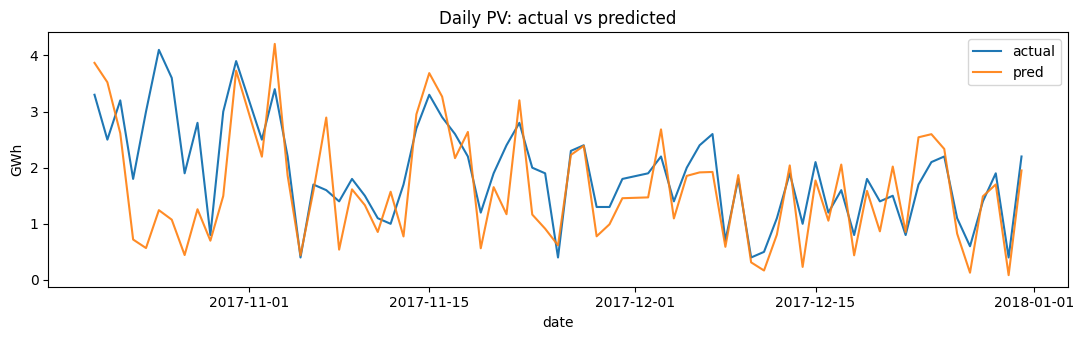

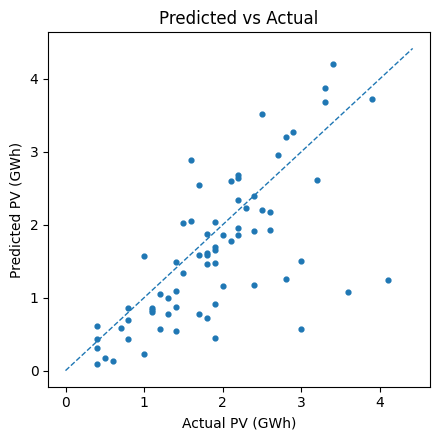

In [3]:
def predict_daily(df_lists_new, model):
    model.eval()
    feat_24 = np.stack([np.stack(df_lists_new[c].to_numpy()) for c in feat_cols], axis=-1).astype(np.float32)  # (N,24,F)
    dates_row = pd.to_datetime(df_lists_new["date"]).to_numpy()
    feat_24 = (feat_24 - mu) / sd

    wins = sliding_window_view(feat_24, window_shape=n, axis=1).transpose((0,1,3,2))
    wins = wins[:, :-1, :, :]  # (N, 24-n, n, F)
    if wins.size == 0:
        return pd.DataFrame(columns=["date","y_hat"])

    N, H, _, F_ = wins.shape
    assert F_ == F
    X_seq = wins.reshape(-1, n, F)  # (samples, n, F)

    keys = pd.DataFrame({"date": np.repeat(dates_row, H)})
    grp = keys.groupby("date").indices
    dates_sorted = np.array(sorted(grp.keys()))

    X_days, ds_days = [], []
    for d in dates_sorted:
        idxs = grp[d]
        X_days.append(torch.from_numpy(X_seq[idxs]).float())  # (M_d, n, F)
        ds_days.append(pd.Timestamp(d))

    def collate_pad(batch):
        Xs, Ds = zip(*batch)
        Mmax = max(x.shape[0] for x in Xs); B, n_, F_ = len(Xs), Xs[0].shape[1], Xs[0].shape[2]
        Xb = torch.zeros((B, Mmax, n_, F_), dtype=torch.float32)
        Mb = torch.zeros((B, Mmax),        dtype=torch.float32)
        for i, x in enumerate(Xs):
            m = x.shape[0]; Xb[i, :m] = x; Mb[i, :m] = 1.0
        return Xb, Mb, Ds

    infer_ds = list(zip(X_days, ds_days))
    infer_dl = DataLoader(infer_ds, batch_size=64, shuffle=False, collate_fn=collate_pad)

    preds, dates_out = [], []
    with torch.no_grad():
        for Xb, Mb, Ds in infer_dl:
            Xb, Mb = Xb.to(device), Mb.to(device)
            y_hat_n = model(Xb, Mb, y_mean_t, y_std_t)
            y_hat   = (y_hat_n*y_std_t + y_mean_t).cpu().numpy()
            preds.append(y_hat); dates_out.extend(Ds)

    y_hat = np.concatenate(preds)
    return pd.DataFrame({"date": pd.to_datetime(dates_out), "y_hat": y_hat}).sort_values("date").reset_index(drop=True)

def test_and_plot(df_lists, pv, model):
    pred = predict_daily(df_lists, model)
    df = pred.merge(pv, on="date", how="inner").sort_values("date")
    if df.empty:
        print("No overlapping dates."); return df
    from sklearn.metrics import mean_absolute_error, r2_score
    mae = mean_absolute_error(df["pv_gwh"], df["y_hat"])
    r2  = r2_score(df["pv_gwh"], df["y_hat"])
    print(f"MAE={mae:.3f}  R2={r2:.3f}  (n={len(df)})")

    plt.figure(figsize=(11,3.5))
    plt.plot(df["date"], df["pv_gwh"], label="actual")
    plt.plot(df["date"], df["y_hat"], label="pred", alpha=0.9)
    plt.title("Daily PV: actual vs predicted"); plt.xlabel("date"); plt.ylabel("GWh")
    plt.legend(); plt.tight_layout(); plt.show()

    lim = max(df["pv_gwh"].max(), df["y_hat"].max()) * 1.05
    plt.figure(figsize=(4.5,4.5))
    plt.scatter(df["pv_gwh"], df["y_hat"], s=12)
    plt.plot([0,lim], [0,lim], lw=1, linestyle="--")
    plt.xlabel("Actual PV (GWh)"); plt.ylabel("Predicted PV (GWh)")
    plt.title("Predicted vs Actual"); plt.tight_layout(); plt.show()
    return df

val_days_arr = pd.to_datetime(list(val_days)).values 

# --- filter df_lists to validation days ---
df_lists_val = df_lists[
    pd.to_datetime(df_lists["date"]).isin(val_days_arr)
].reset_index(drop=True)

# --- filter pv_daily to validation days ---
pv_val = pv_daily[
    pd.to_datetime(pv_daily["date"]).isin(val_days_arr)
].sort_values("date").reset_index(drop=True)

df_eval = test_and_plot(df_lists_val, pv_val, model)

# Model Comparison: Validation Performance (MAE & R²)

- LSTM Achieves the Best Validation Performance

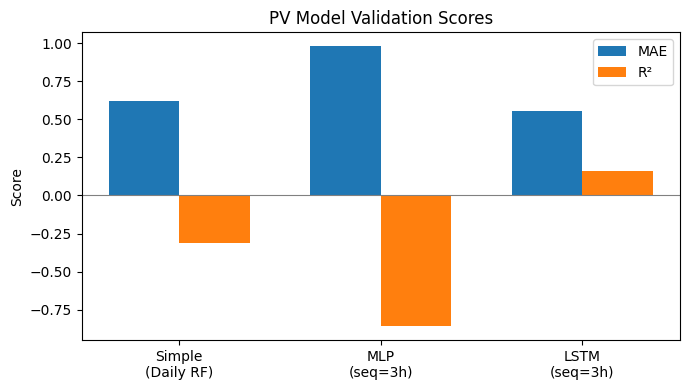

In [4]:
import matplotlib.pyplot as plt
import numpy as np

models = ["Simple\n(Daily RF)", "MLP\n(seq=3h)", "LSTM\n(seq=3h)"]
mae = [0.622, 0.980, 0.555]
r2  = [-0.311, -0.858, 0.163]

x = np.arange(len(models))
w = 0.35

fig, ax1 = plt.subplots(1, 1, figsize=(7,4))
ax1.bar(x - w/2, mae, width=w, label="MAE")
ax1.bar(x + w/2, r2,  width=w, label="R²")
ax1.set_xticks(x); ax1.set_xticklabels(models)
ax1.set_ylabel("Score")
ax1.set_title("PV Model Validation Scores")
ax1.axhline(0, color="gray", lw=0.8)
ax1.legend()
plt.tight_layout(); plt.show()
